In [5]:
import pandas as pd
path="movie_metadata.csv"

In [6]:
import warnings
warnings.filterwarnings('ignore')
from preprocessing import data_clean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
data1=data_clean(path)
labels=data1.imdb_score.values
import numpy as np

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print ('MSE: %2.3f' % mse)
    return mse




def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print ('R2: %2.3f' % r2)
     return r2

def two_score(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=True)




genres_split=data1.genres.str.get_dummies().add_prefix('Part_')
content_rating_split=data1.content_rating.str.get_dummies().add_prefix('Rating_')
genres_split=genres_split.astype("category")
content_rating=content_rating_split.astype("category")
all_data1=pd.concat([data1.drop(columns=["genres","content_rating"]),genres_split,content_rating_split],axis=1)
all_data=all_data1.drop(columns=["imdb_score"])
all_data["revenue"]=all_data["gross"]-all_data["budget"]
all_data["gross"]=np.log10(all_data["gross"])
all_data["budget"]=np.log10(all_data["budget"])

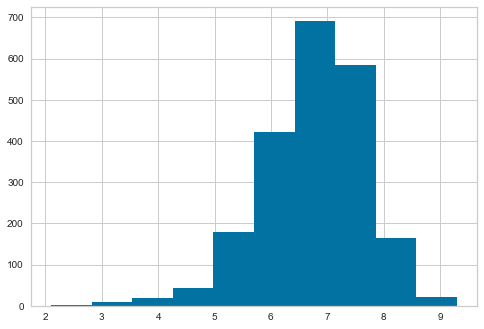

In [22]:
all_data1[all_data1.Part_Drama==1].imdb_score.hist()

In [15]:
from sklearn.ensemble import RandomForestRegressor
Xtrain,Xtest,ytrain,ytest=train_test_split(all_data,labels,test_size=0.40,random_state=42)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
two_score(ytest,rf.predict(Xtest))

MSE: 0.713
R2: 0.376


0.37573700225843465

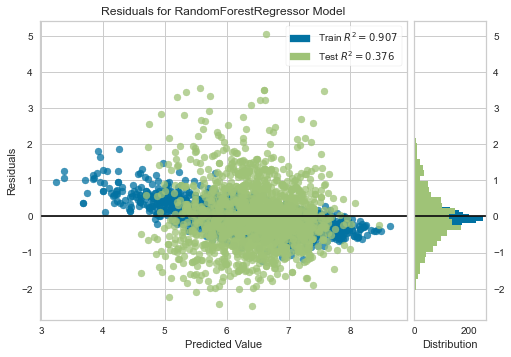

In [17]:
from yellowbrick.regressor import ResidualsPlot
#best_clf_ridge = searchCV.best_estimator_.named_steps['rdg']


visualizer1=ResidualsPlot(rf)
visualizer1.fit(Xtrain, ytrain) # Fit the training data to the visualizer

visualizer1.score(Xtest, ytest)  # Evaluate the model on the test data
visualizer1.show() 

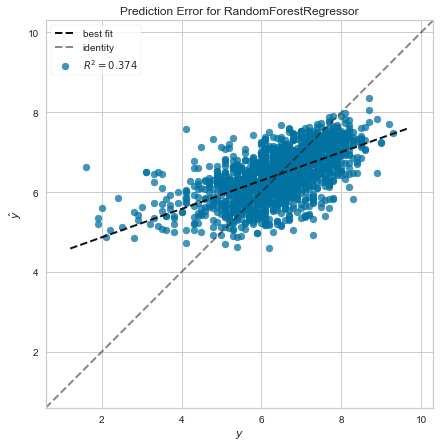

In [302]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(rf,size=(500,700))

visualizer.fit(Xtrain, ytrain)  # Fit the training data to the visualizer
visualizer.score(Xtest, ytest)  # Evaluate the model on the test data
visualizer.show()  


In [303]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(rf)

In [304]:
Xtest=Xtest.reset_index(drop=True)
predicted_y=rf.predict(Xtest)

In [305]:
import numpy as np
print("index max rating"+ str(np.where(predicted_y==np.amax(predicted_y))))
print("index min rating" + str(np.where(predicted_y==np.amin(predicted_y))))
print("index median rating" + str(np.where(predicted_y==np.median(predicted_y))))

index max rating(array([223]),)
index min rating(array([465]),)
index median rating(array([ 947, 1366]),)


In [306]:
Xtest.loc[[223]]

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,budget,gross,facenumber_in_poster,Part_Action,Part_Adventure,...,Rating_NC-17,Rating_None,Rating_Not Rated,Rating_PG,Rating_PG-13,Rating_Passed,Rating_R,Rating_Unrated,Rating_X,revenue
223,16000.0,5000.0,857.0,0.0,23052.0,7.973128,8.53209,1.0,1,1,...,0,0,0,0,1,0,0,0,0,246478898.0


In [307]:
print("actual_rating= "+str(ytest[223]),"predicted_rating= "+str(predicted_y[223]))

choosen_instance=Xtest.loc[[223]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance,feature_names=all_data.columns)

actual_rating= 8.7 predicted_rating= 8.355999999999993


In [308]:
import matplotlib.pyplot as plt




print("actual_rating= "+str(ytest[465]),"predicted_rating= "+str(predicted_y[465]))

choosen_instance=Xtest.loc[[465]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance,feature_names=all_data.columns)


actual_rating= 6.2 predicted_rating= 4.598000000000001


In [309]:
print("actual_rating= "+str(ytest[947]),"predicted_rating= "+str(predicted_y[947]))

choosen_instance=Xtest.loc[[947]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, choosen_instance,feature_names=all_data.columns)

actual_rating= 5.1 predicted_rating= 6.495999999999999


In [310]:
shap_values = explainer.shap_values(Xtest)


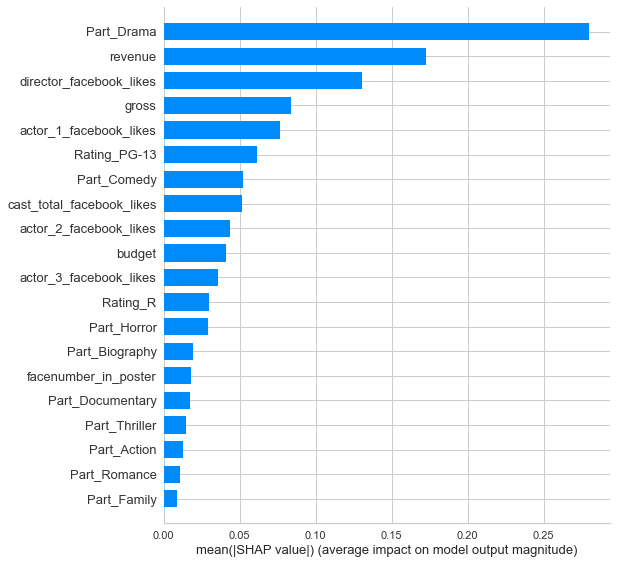

In [311]:
shap.summary_plot(shap_values, Xtest, plot_type="bar",feature_names=all_data.columns)

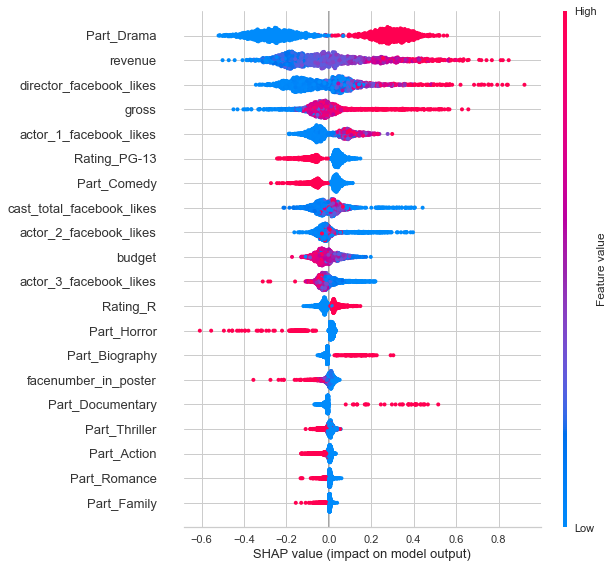

In [312]:

shap.summary_plot(shap_values, Xtest,feature_names=all_data.columns)

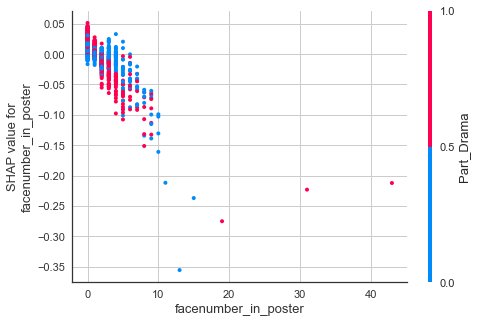

In [313]:
shap.dependence_plot("facenumber_in_poster", shap_values, Xtest,feature_names=all_data.columns)

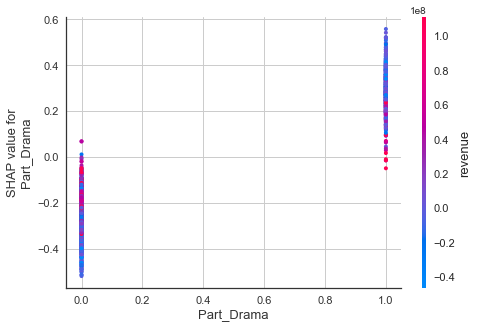

In [314]:
shap.dependence_plot("Part_Drama", shap_values, Xtest,feature_names=all_data.columns)

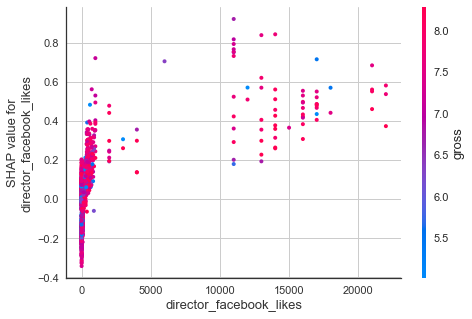

In [315]:
shap.dependence_plot("director_facebook_likes", shap_values, Xtest,feature_names=all_data.columns)

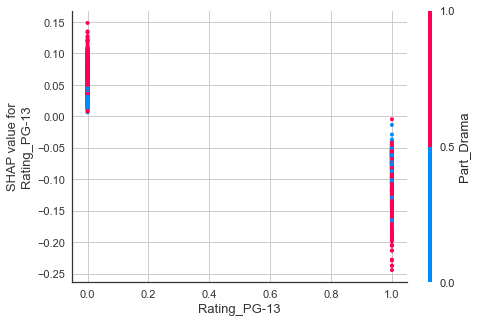

In [316]:
shap.dependence_plot("Rating_PG-13", shap_values, Xtest,feature_names=all_data.columns)


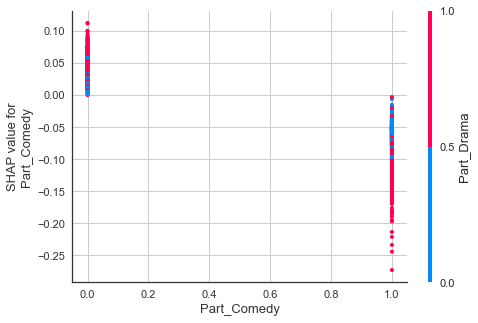

In [317]:
shap.dependence_plot("Part_Comedy", shap_values, Xtest,feature_names=all_data.columns)

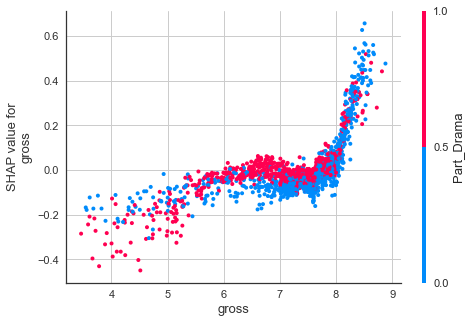

In [318]:
shap.dependence_plot("gross", shap_values, Xtest,feature_names=all_data.columns)

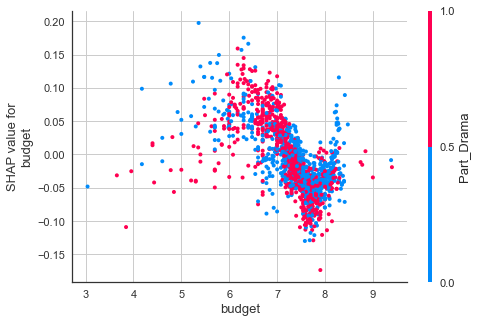

In [319]:
shap.dependence_plot("budget", shap_values, Xtest,feature_names=all_data.columns)

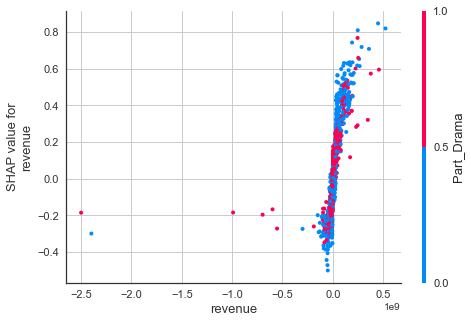

In [320]:
shap.dependence_plot("revenue", shap_values, Xtest,feature_names=all_data.columns)